In [1]:
import tensorflow as tf
tf.keras.backend.clear_session()
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.0


# 一 构建一个简单的网络层

In [2]:
# 定义网络层就是：设置网络权重和输出到输入的计算过程
class MyLayer(layers.Layer):
    def __init__(self, input_dim=32, unit=32):
        super(MyLayer, self).__init__()
        
        w_init = tf.random_normal_initializer()
        self.weight = tf.Variable(initial_value=w_init(
            shape=(input_dim, unit), dtype=tf.float32), trainable=True)
        
        b_init = tf.zeros_initializer()
        self.bias = tf.Variable(initial_value=b_init(
            shape=(unit,), dtype=tf.float32), trainable=True)
    
    def call(self, inputs):
        return tf.matmul(inputs, self.weight) + self.bias
        
x = tf.ones((3,5))
my_layer = MyLayer(5, 4)
out = my_layer(x)
print(out)

tf.Tensor(
[[-0.1261304  -0.07474548 -0.07380037 -0.08312537]
 [-0.1261304  -0.07474548 -0.07380037 -0.08312537]
 [-0.1261304  -0.07474548 -0.07380037 -0.08312537]], shape=(3, 4), dtype=float32)


In [3]:
# 按上面构建网络层，图层会自动跟踪权重w和b，当然我们也可以直接用add_weight的方法构建权重
class MyLayer(layers.Layer):
    def __init__(self, input_dim=32, unit=32):
        super(MyLayer, self).__init__()
        self.weight = self.add_weight(shape=(input_dim, unit),
                                     initializer=keras.initializers.RandomNormal(),
                                     trainable=True)
        self.bias = self.add_weight(shape=(unit,),
                                   initializer=keras.initializers.Zeros(),
                                   trainable=True)
    
    def call(self, inputs):
        return tf.matmul(inputs, self.weight) + self.bias
        
x = tf.ones((3,5))
my_layer = MyLayer(5, 4)
out = my_layer(x)
print(out)

tf.Tensor(
[[-0.01372903  0.12834595  0.27237916 -0.1743208 ]
 [-0.01372903  0.12834595  0.27237916 -0.1743208 ]
 [-0.01372903  0.12834595  0.27237916 -0.1743208 ]], shape=(3, 4), dtype=float32)


In [4]:
# 也可以设置不可训练的权重，trainable=False
class AddLayer(layers.Layer):
    def __init__(self, input_dim=32):
        super(AddLayer, self).__init__()
        self.sum = self.add_weight(shape=(input_dim,),
                                     initializer=keras.initializers.Zeros(),
                                     trainable=False)
       
    def call(self, inputs):
        self.sum.assign_add(tf.reduce_sum(inputs, axis=0))
        return self.sum
        
x = tf.ones((3,3))
my_layer = AddLayer(3)
out = my_layer(x)
print(out.numpy())
out = my_layer(x)
print(out.numpy())
print('weight:', my_layer.weights)
print('non-trainable weight:', my_layer.non_trainable_weights)
print('trainable weight:', my_layer.trainable_weights)

[3. 3. 3.]
[6. 6. 6.]
weight: [<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([6., 6., 6.], dtype=float32)>]
non-trainable weight: [<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([6., 6., 6.], dtype=float32)>]
trainable weight: []


In [6]:
# 当定义网络时不知道网络的维度是可以重写build()函数，用获得的shape构建网络
class MyLayer(layers.Layer):
    def __init__(self, unit=32):
        super(MyLayer, self).__init__()
        self.unit = unit
        
    def build(self, input_shape):
        self.weight = self.add_weight(shape=(input_shape[-1], self.unit),
                                     initializer=keras.initializers.RandomNormal(),
                                     trainable=True)
        self.bias = self.add_weight(shape=(self.unit,),
                                   initializer=keras.initializers.Zeros(),
                                   trainable=True)
    
    def call(self, inputs):
        return tf.matmul(inputs, self.weight) + self.bias
        

my_layer = MyLayer(3)
x = tf.ones((3,5)) # build()中shape传入5
out = my_layer(x)
print(out)

my_layer = MyLayer(3) #一定要重新初始化
x = tf.ones((2,2))
out = my_layer(x)
print(out)

tf.Tensor(
[[ 0.23127687 -0.04619538 -0.01080534]
 [ 0.23127687 -0.04619538 -0.01080534]
 [ 0.23127687 -0.04619538 -0.01080534]], shape=(3, 3), dtype=float32)
tf.Tensor(
[[-0.16376385  0.10757498 -0.05582384]
 [-0.16376385  0.10757498 -0.05582384]], shape=(2, 3), dtype=float32)


# 二 使用子层递归构建网络层

In [7]:
class MyBlock(layers.Layer):
    def __init__(self):
        super(MyBlock, self).__init__()
        self.layer1 = MyLayer(32)
        self.layer2 = MyLayer(16)
        self.layer3 = MyLayer(2)
    def call(self, inputs):
        h1 = self.layer1(inputs)
        h1 = tf.nn.relu(h1)
        h2 = self.layer2(h1)
        h2 = tf.nn.relu(h2)
        return self.layer3(h2)
    
my_block = MyBlock()
print('trainable weights:', len(my_block.trainable_weights))

y = my_block(tf.ones(shape=(3, 64)))
# 构建网络在build()里面，所以执行了才有网络
print('trainable weights:', len(my_block.trainable_weights))

trainable weights: 0
trainable weights: 6


In [8]:
# 可以通过构建网络层的方法来手机loss
class LossLayer(layers.Layer):
  
  def __init__(self, rate=1e-2):
    super(LossLayer, self).__init__()
    self.rate = rate
  
  def call(self, inputs):
    self.add_loss(self.rate * tf.reduce_sum(inputs))
    return inputs

class OutLayer(layers.Layer):
    def __init__(self):
        super(OutLayer, self).__init__()
        self.loss_fun=LossLayer(1e-2)
    def call(self, inputs):
        return self.loss_fun(inputs)
    
my_layer = OutLayer()
print(len(my_layer.losses)) # 还未call

y = my_layer(tf.zeros(1,1))
print(len(my_layer.losses)) # 执行call之后

y = my_layer(tf.zeros(1,1))
print(len(my_layer.losses)) # call之前会重新置0

0
1
1


In [9]:
# 如果中间调用了keras网络层，里面的正则化loss也会被加入进来
class OuterLayer(layers.Layer):

    def __init__(self):
        super(OuterLayer, self).__init__()
        self.dense = layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(1e-3))
    
    def call(self, inputs):
        return self.dense(inputs)


my_layer = OuterLayer()
y = my_layer(tf.zeros((1,1)))
print(my_layer.losses) 
print(my_layer.weights) 

[<tf.Tensor: shape=(), dtype=float32, numpy=0.0017986915>]
[<tf.Variable 'outer_layer/dense/kernel:0' shape=(1, 32) dtype=float32, numpy=
array([[ 0.40529805, -0.1314427 ,  0.2719711 ,  0.25580543, -0.26228547,
         0.01552978, -0.16633809,  0.01763368, -0.13327768, -0.04971039,
        -0.09338847,  0.08145285,  0.27116197,  0.20952988,  0.38576114,
        -0.3608946 , -0.35773382, -0.35904008, -0.20193139,  0.3248235 ,
        -0.14680454, -0.35808507,  0.07635039, -0.2777757 , -0.09260514,
         0.14734203, -0.14392263, -0.36047322, -0.12587467,  0.26037157,
         0.19422245, -0.10205576]], dtype=float32)>, <tf.Variable 'outer_layer/dense/bias:0' shape=(32,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>]


# 三 其他网络层配置
是自己的网络层可以序列化

In [10]:
class Linear(layers.Layer):

    def __init__(self, units=32, **kwargs):
        super(Linear, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
    def get_config(self):
        config = super(Linear, self).get_config()
        config.update({'units':self.units})
        return config
    
layer = Linear(125)
config = layer.get_config()
print(config)

{'name': 'linear', 'trainable': True, 'dtype': 'float32', 'units': 125}


In [11]:
# 配置只有训练时可以执行的网络层
class MyDropout(layers.Layer):
    def __init__(self, rate, **kwargs):
        super(MyDropout, self).__init__(**kwargs)
        self.rate = rate
    def call(self, inputs, training=None):
        return tf.cond(training, 
                       lambda: tf.nn.dropout(inputs, rate=self.rate),
                       lambda: inputs)

# 四 构建自己的模型
通常，我们使用Layer类来定义内部计算块，并使用Model类来定义外部模型 - 即要训练的对象。

Model类与Layer的区别：

* 它公开了内置的训练，评估和预测循环（model.fit(),model.evaluate(),model.predict()）。
* 它通过model.layers属性公开其内层列表。
* 它公开了保存和序列化API。

下面通过构建一个变分自编码器（VAE），来介绍如何构建自己的网络。

In [12]:
# 采样网络
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5*z_log_var) * epsilon
# 编码器
class Encoder(layers.Layer):
    def __init__(self, latent_dim=32, 
                intermediate_dim=64, name='encoder', **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation='relu')
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()
        
    def call(self, inputs):
        h1 = self.dense_proj(inputs)
        z_mean = self.dense_mean(h1)
        z_log_var = self.dense_log_var(h1)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z
        
# 解码器
class Decoder(layers.Layer):
    def __init__(self, original_dim, 
                 intermediate_dim=64, name='decoder', **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation='relu')
        self.dense_output = layers.Dense(original_dim, activation='sigmoid')
    def call(self, inputs):
        h1 = self.dense_proj(inputs)
        return self.dense_output(h1)
    
# 变分自编码器
class VAE(tf.keras.Model):
    def __init__(self, original_dim, latent_dim=32, 
                intermediate_dim=64, name='encoder', **kwargs):
        super(VAE, self).__init__(name=name, **kwargs)
    
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim,
                              intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim=original_dim,
                              intermediate_dim=intermediate_dim)
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        kl_loss = -0.5*tf.reduce_sum(
            z_log_var-tf.square(z_mean)-tf.exp(z_log_var)+1)
        self.add_loss(kl_loss)
        return reconstructed

(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
vae = VAE(784,32,64)

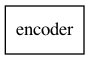

In [13]:
keras.utils.plot_model(vae, "vae.png", show_shapes=True)

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=3, batch_size=64) 

Epoch 1/3
938/938 [==============================] - 2s 1ms/step - loss: 4.1776
Epoch 2/3
938/938 [==============================] - 1s 1ms/step - loss: 0.0695
Epoch 3/3
938/938 [==============================] - 1s 1ms/step - loss: 0.0680


In [15]:
# 编写训练方法
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

original_dim = 784
vae = VAE(original_dim, 64, 32)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mse_loss_fn = tf.keras.losses.MeanSquaredError()

loss_metric = tf.keras.metrics.Mean()

# 每个epoch迭代.
for epoch in range(3):
    print('Start of epoch %d' % (epoch,))

  # 取出每个batch的数据并训练.
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            reconstructed = vae(x_batch_train)
            # 计算 reconstruction loss
            loss = mse_loss_fn(x_batch_train, reconstructed)
            loss += sum(vae.losses)  # 添加 KLD regularization loss
      
        grads = tape.gradient(loss, vae.trainable_variables)
        optimizer.apply_gradients(zip(grads, vae.trainable_variables))
    
        loss_metric(loss)
    
        if step % 100 == 0:
            print('step %s: mean loss = %s' % (step, loss_metric.result()))

Start of epoch 0
step 0: mean loss = tf.Tensor(140.05846, shape=(), dtype=float32)
step 100: mean loss = tf.Tensor(4.182739, shape=(), dtype=float32)
step 200: mean loss = tf.Tensor(2.147588, shape=(), dtype=float32)
step 300: mean loss = tf.Tensor(1.4623474, shape=(), dtype=float32)
step 400: mean loss = tf.Tensor(1.1164762, shape=(), dtype=float32)
step 500: mean loss = tf.Tensor(0.90849644, shape=(), dtype=float32)
step 600: mean loss = tf.Tensor(0.76945853, shape=(), dtype=float32)
step 700: mean loss = tf.Tensor(0.66996735, shape=(), dtype=float32)
step 800: mean loss = tf.Tensor(0.59526765, shape=(), dtype=float32)
step 900: mean loss = tf.Tensor(0.5367659, shape=(), dtype=float32)
Start of epoch 1
step 0: mean loss = tf.Tensor(0.5178606, shape=(), dtype=float32)
step 100: mean loss = tf.Tensor(0.47474447, shape=(), dtype=float32)
step 200: mean loss = tf.Tensor(0.43919283, shape=(), dtype=float32)
step 300: mean loss = tf.Tensor(0.40925246, shape=(), dtype=float32)
step 400: mea

## 1保存全模型
可以对整个模型进行保存，其保存的内容包括：

* 该模型的架构
* 模型的权重（在训练期间学到的）
* 模型的训练配置（你传递给编译的），如果有的话
* 优化器及其状态（如果有的话）（这使您可以从中断的地方重新启动训练）